# Distributed Big Data System Project:

# Dataset: Consumer-Complaint-Database

DataSet: The dataset contains different information of complaints that customers have made about a multiple products and services in the financial sector, such us Credit Reports, Student Loans, Money Transfer, etc. * Target Variable: "Consumer disputed?" * link: https://www.kaggle.com/selener/consumer-complaint-database.


*consumer_disputed_string(Whether the consumer disputed the company's response).This is the target variable.

# Package import:

In [0]:
#Pyspark related

import os
import time
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import col, unix_timestamp, to_date, when 
from pyspark.sql import functions as F
from pyspark import SparkConf, SQLContext
import pyspark
from pyspark.sql import SparkSession, functions as F 
from pyspark.sql.types import *

sc =SparkContext()
sqlc = SQLContext(sc)

In [0]:
#Plotting related
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline 
from pyspark.sql.functions import datediff, to_date, lit
# random state
SEED=100

In [0]:
# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)

In [0]:
#Creating the spark session under the name of ConsumerComplain
spark = pyspark.sql.SparkSession.builder.appName('ConsumerComplain').getOrCreate()
sc = spark.sparkContext
sqc = SQLContext(sc) # spark_df = sqlContext.createDataFrame(pandas_df)
sc.setLogLevel("INFO")

print("All Versions:")
print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib,pyspark]])

All Versions:
[('numpy', '1.20.3'), ('pandas', '1.3.4'), ('seaborn', '0.11.2'), ('matplotlib', '3.4.3'), ('pyspark', '3.3.0')]
/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Loading Dataset

In [0]:
data = (spark.read.format("csv").options(header=True, inferSchema=True).load("/FileStore/tables/data.csv"))

print('nrows = ', data.count(), 'ncols = ', len(data.columns))

data.limit(5).toPandas()

nrows =  1720532 ncols =  18


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,None,None,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,None,Web,05/10/2019,In progress,Yes,N/A,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,None,None,BOEING EMPLOYEES CREDIT UNION,WA,98204,None,N/A,Referral,05/10/2019,Closed with explanation,Yes,N/A,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,None,None,CURO Intermediate Holdings,TX,751XX,None,None,Web,05/10/2019,Closed with explanation,Yes,N/A,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,None,None,Ad Astra Recovery Services Inc,LA,708XX,None,None,Web,05/10/2019,Closed with explanation,Yes,N/A,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,None,None,ALLY FINANCIAL INC.,AZ,85205,None,N/A,Postal mail,05/10/2019,In progress,Yes,N/A,3238460


In [0]:
Complt_df=data

# Data Pre-Processing

In [0]:
#Change the coloumn names and create a new Dataframe

oldColumns = Complt_df.schema.names
newColumns = ["Date_Rxd", "Product","Sub_Product", "Issue","Sub_Issue","Consumer_complaint_narrative","Company_Pub_Resp", "Company", "State",           \
              "Zip_Code","Tags", "Cnsmr_Consent", "Submit_Via", "Date_Sent", "Comp_Resp_Cnsmr", "Timely_Resp","Cnsmr_Disp", \
              "ComplaintID"]

Complaint_df = reduce(lambda Complt_df, idx: Complt_df.withColumnRenamed(oldColumns[idx], newColumns[idx]),         \
                      range(len(oldColumns)), Complt_df)


#Bring the date to a uniform formatted string

Complaint_df = Complaint_df.withColumn("Date_Rxd",F.translate(F.col("Date_Rxd"), "-", "/"))
Complaint_df.printSchema()
Complaint_df.show(2)

root
 |-- Date_Rxd: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub_Product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub_Issue: string (nullable = true)
 |-- Consumer_complaint_narrative: string (nullable = true)
 |-- Company_Pub_Resp: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip_Code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Cnsmr_Consent: string (nullable = true)
 |-- Submit_Via: string (nullable = true)
 |-- Date_Sent: string (nullable = true)
 |-- Comp_Resp_Cnsmr: string (nullable = true)
 |-- Timely_Resp: string (nullable = true)
 |-- Cnsmr_Disp: string (nullable = true)
 |-- ComplaintID: string (nullable = true)

+----------+--------------------+--------------------+-------------------+--------------------+----------------------------+----------------+--------------------+-----+--------+--------------+-------------+----------+----------+---

In [0]:
#To extract the only date format out of the column. Then i realized it is not impacting on vary minimal vlaues.
#Complaint_df = Complaint_df.withColumn("Date_Rxd", F.regexp_extract(Complaint_df.Date_Rxd, r"(\b(\d{2})+/\b(\d{2})+/\b(\d{4}))", 0))          

# Conver the string filed to datafield 
Complaint_df = Complaint_df.select('*', to_date(Complaint_df['Date_Rxd'], 
                          'MM/dd/yyyy').alias('Date_Rxd_dt'))

Complaint_df = Complaint_df.select('*', 
                    to_date(Complaint_df['Date_Sent'], 
                    'MM/dd/yyyy').alias('Date_Sent_dt'))

# add time difference between receipt and sent to company
Complaint_df = Complaint_df.withColumn('transit_time',
                       datediff(Complaint_df['Date_Sent_dt'],
                       Complaint_df['Date_Rxd_dt']))

In [0]:
#Delete the fields as time difference considered into dataset.
Complaint_df=Complaint_df.drop('Date_Sent_dt')
Complaint_df=Complaint_df.drop('Date_Rxd_dt')
Complaint_df=Complaint_df.drop('Date_Rxd')
Complaint_df=Complaint_df.drop('Date_Sent')

In [0]:
#Print top 5 unique values and check how much percentage of null values in the particular column.
print(Complaint_df.groupBy('Zip_Code').count().sort('count', ascending=False).show(5))
print(Complaint_df.groupBy('Consumer_complaint_narrative').count().sort('count', ascending=False).show(5))
print(Complaint_df.groupBy('Company_Pub_Resp').count().sort('count', ascending=False).show(5))
print(Complaint_df.groupBy('Tags').count().sort('count', ascending=False).show(5))

+--------------------+------+
|            Zip_Code| count|
+--------------------+------+
|                null|514477|
|Closed with expla...| 45739|
|                 Web| 13716|
|    Consent provided|  7915|
|Closed with non-m...|  6794|
+--------------------+------+
only showing top 5 rows

None
+----------------------------+-------+
|Consumer_complaint_narrative|  count|
+----------------------------+-------+
|                        null|1234573|
|               Servicemember|   5663|
|              Older American|   4415|
|                          CA|   2091|
|        Company has respo...|   1601|
+----------------------------+-------+
only showing top 5 rows

None
+--------------------+-------+
|    Company_Pub_Resp|  count|
+--------------------+-------+
|                null|1187731|
|Company has respo...| 264377|
|    Consent provided|  56948|
|Company believes ...|  51298|
|Company chooses n...|  44641|
+--------------------+-------+
only showing top 5 rows

None
+---------

In [0]:
Complaint_df=Complaint_df.drop('Zip_Code')

In [0]:
Complaint_df=Complaint_df.drop('Consumer_complaint_narrative')
Complaint_df=Complaint_df.drop('Company_Pub_Resp')
Complaint_df=Complaint_df.drop('Tags')

In [0]:
#Verfiy the target variable in the context of null values.
print(Complaint_df.groupBy('Cnsmr_Disp').count().sort('count', ascending=False).show(10))

+--------------------+------+
|          Cnsmr_Disp| count|
+--------------------+------+
|                  No|575847|
|                null|543865|
|                 N/A|429482|
|                 Yes|140079|
|Closed with expla...|  4346|
|                 Web|  2983|
|    Consent provided|  2510|
|Closed with non-m...|   568|
|Closed with monet...|   411|
|Company has respo...|   242|
+--------------------+------+
only showing top 10 rows

None


In [0]:
#Consider only yes and no values as the main idea is Bi-classification.
Complaint_df=Complaint_df[(Complaint_df.Cnsmr_Disp=='Yes') | (Complaint_df.Cnsmr_Disp=='No')]

In [0]:
#Complaint_df = Complaint_df.withColumn("Cnsmr_Disp", when(col("Cnsmr_Disp") == "Yes",1).otherwise(0))
# print unique value counts in target variable
print(Complaint_df.groupBy('Cnsmr_Disp').count().sort('count', ascending=False).show(10))

+----------+------+
|Cnsmr_Disp| count|
+----------+------+
|        No|575847|
|       Yes|140079|
+----------+------+

None


In [0]:
Complaint_df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Sub_Product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub_Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Cnsmr_Consent: string (nullable = true)
 |-- Submit_Via: string (nullable = true)
 |-- Comp_Resp_Cnsmr: string (nullable = true)
 |-- Timely_Resp: string (nullable = true)
 |-- Cnsmr_Disp: string (nullable = true)
 |-- ComplaintID: string (nullable = true)
 |-- transit_time: integer (nullable = true)



In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
#To keep the table, readable to sqlQuery.
from pyspark.sql.functions import udf
Complaint_df.registerTempTable("Complaint_df")
Complaint_df.cache()

/databricks/spark/python/pyspark/sql/dataframe.py:234: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
Out[23]: DataFrame[Product: string, Sub_Product: string, Issue: string, Sub_Issue: string, Company: string, State: string, Cnsmr_Consent: string, Submit_Via: string, Comp_Resp_Cnsmr: string, Timely_Resp: string, Cnsmr_Disp: string, ComplaintID: string, transit_time: int]

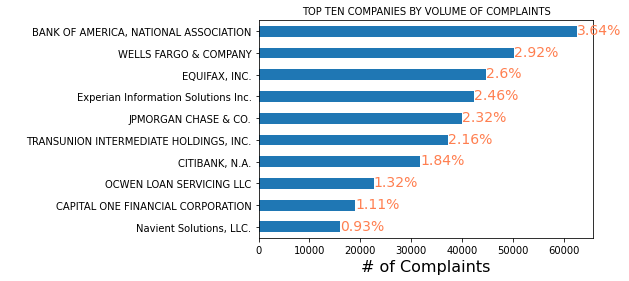

In [0]:
## What are the top 10 companies by the volume of complaints. Indicate the percentage of complaints for 
# each company against the total number of complaints.

Total = Complt_df.count()

TopTenComp = sqlContext.sql("SELECT Company, count(1) AS TotComplaints FROM Complaint_df          \
                            GROUP BY Company                                                      \
                            ORDER BY count(1) DESC LIMIT 10")

plots = TopTenComp.toPandas()

ax=plots.plot(kind='barh',
              x='Company',
              y='TotComplaints',
              legend=None)

plt.title('TOP TEN COMPANIES BY VOLUME OF COMPLAINTS', fontsize=10)
plt.ylabel(' ', fontsize = 16)
plt.xlabel('# of Complaints', fontsize = 16)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total)*100, 2))+'%', fontsize=14, color = 'Coral')
ax.invert_yaxis()

In [0]:
print(Complaint_df.groupBy('Comp_Resp_Cnsmr').count().sort('count', ascending=False).show(10))

+--------------------+------+
|     Comp_Resp_Cnsmr| count|
+--------------------+------+
|Closed with expla...|531238|
|Closed with non-m...| 88787|
|Closed with monet...| 46395|
|Closed without re...| 17868|
|              Closed| 16287|
|  Closed with relief|  5304|
|   Untimely response|  2658|
|          09/09/2017|    49|
|          09/08/2017|    34|
|          02/21/2019|    24|
+--------------------+------+
only showing top 10 rows

None


In [0]:
#Consolidate the columns which need to OneHotEncode top-ten unque values.
truncate_columns=['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Comp_Resp_Cnsmr']
numerical_cols = []

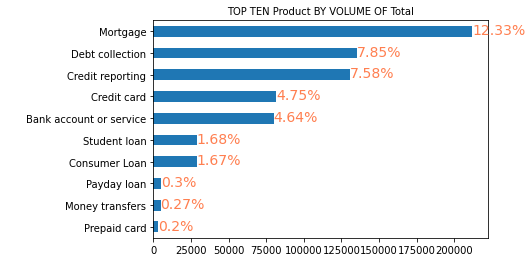

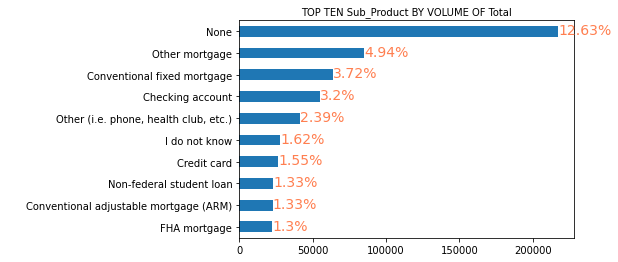

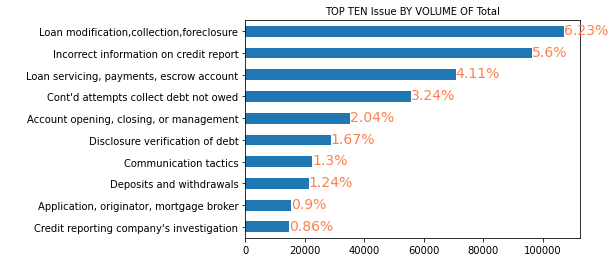

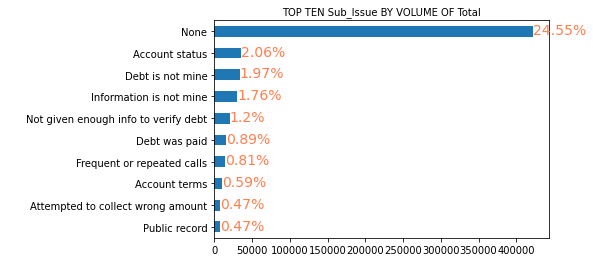

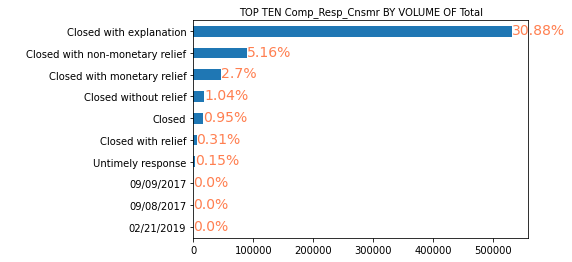

In [0]:
Total = Complt_df.count()

for coln in truncate_columns:
    Total = Complt_df.count()
    TopTen = sqlContext.sql("SELECT "+coln+", count(1) AS TotCounts FROM Complaint_df          \
                            GROUP BY "+coln+"                                                      \
                            ORDER BY count(1) DESC LIMIT 10")
    
    plots = TopTen.toPandas()

    ax=plots.plot(kind='barh',
              x=coln,
              y='TotCounts',
              legend=None)

    plt.title('TOP TEN '+coln+' BY VOLUME OF Total', fontsize=10)
    plt.ylabel(' ', fontsize = 16)
    #plt.xlabel('# of ', fontsize = 16)

    for i in ax.patches:
        ax.text(i.get_width()+.3, i.get_y()+.38, \
           str(round((i.get_width()/Total)*100, 2))+'%', fontsize=14, color = 'Coral')
    ax.invert_yaxis()

In [0]:
# One Hot encoding
for coln in truncate_columns:
    TopTenComp = sqlContext.sql("SELECT "+coln+", count(1) AS TotComplaints FROM Complaint_df          \
                            GROUP BY "+coln+"                                                      \
                            ORDER BY count(1) DESC LIMIT 10")
    
    for i,k in enumerate(TopTenComp.collect()):
        numerical_cols.append(coln+"_"+str(i))
        Complaint_df= Complaint_df.select('*').withColumn(coln+"_"+str(i), when(col(coln) == k[coln],1).otherwise(0))

In [0]:
#OneHotEncode "Company", top-15 unique values as it is eqally distributed.
TopTen_Company = sqlContext.sql("SELECT Company, count(1) AS TotState FROM Complaint_df          \
                            GROUP BY Company                                                      \
                            ORDER BY count(1) DESC LIMIT 15")

for i,k in enumerate(TopTen_Company.collect()):
    numerical_cols.append("Company"+str(i))
    Complaint_df = Complaint_df.withColumn("Company"+str(i), when(col('Company') == k.Company,1).otherwise(0))

In [0]:
Complaint_df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Sub_Product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub_Issue: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Cnsmr_Consent: string (nullable = true)
 |-- Submit_Via: string (nullable = true)
 |-- Comp_Resp_Cnsmr: string (nullable = true)
 |-- Timely_Resp: string (nullable = true)
 |-- Cnsmr_Disp: string (nullable = true)
 |-- ComplaintID: string (nullable = true)
 |-- transit_time: integer (nullable = true)
 |-- Product_0: integer (nullable = false)
 |-- Product_1: integer (nullable = false)
 |-- Product_2: integer (nullable = false)
 |-- Product_3: integer (nullable = false)
 |-- Product_4: integer (nullable = false)
 |-- Product_5: integer (nullable = false)
 |-- Product_6: integer (nullable = false)
 |-- Product_7: integer (nullable = false)
 |-- Product_8: integer (nullable = false)
 |-- Product_9: integer (nullable = false)
 |-- Sub_Product_0: in

In [0]:
#As i wanted to train the model with pure values, removing all null values in the dataset.

for coln in Complaint_df.columns:
    Complaint_df = Complaint_df.where(col(coln).isNotNull())
print(Complaint_df.count())

155922


# OneHotEncoding and pipeline

In [0]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

categoricalColumns = ["State","Cnsmr_Consent","Submit_Via","Timely_Resp"]

numerical_cols.append("transit_time")

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Cnsmr_Disp', outputCol = 'label')
stages += [label_stringIdx]

numericCols = numerical_cols

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [0]:
#drop the fileds after oneHot encoded.
Complaint_df=Complaint_df.drop('Product')
Complaint_df=Complaint_df.drop('Sub_Product')
Complaint_df=Complaint_df.drop('Issue')
Complaint_df=Complaint_df.drop('Company')
# Complaint_df=Complaint_df.drop('State')
# Complaint_df=Complaint_df.drop('Cnsmr_Consent')
# Complaint_df=Complaint_df.drop('Submit_Via')
Complaint_df=Complaint_df.drop('Sub_Issue')
Complaint_df=Complaint_df.drop('ComplaintID')
Complaint_df=Complaint_df.drop('Comp_Resp_Cnsmr')
# Complaint_df=Complaint_df.drop('Timely_Resp')

In [0]:
print(Complaint_df.printSchema())

root
 |-- State: string (nullable = true)
 |-- Cnsmr_Consent: string (nullable = true)
 |-- Submit_Via: string (nullable = true)
 |-- Timely_Resp: string (nullable = true)
 |-- Cnsmr_Disp: string (nullable = true)
 |-- transit_time: integer (nullable = true)
 |-- Product_0: integer (nullable = false)
 |-- Product_1: integer (nullable = false)
 |-- Product_2: integer (nullable = false)
 |-- Product_3: integer (nullable = false)
 |-- Product_4: integer (nullable = false)
 |-- Product_5: integer (nullable = false)
 |-- Product_6: integer (nullable = false)
 |-- Product_7: integer (nullable = false)
 |-- Product_8: integer (nullable = false)
 |-- Product_9: integer (nullable = false)
 |-- Sub_Product_0: integer (nullable = false)
 |-- Sub_Product_1: integer (nullable = false)
 |-- Sub_Product_2: integer (nullable = false)
 |-- Sub_Product_3: integer (nullable = false)
 |-- Sub_Product_4: integer (nullable = false)
 |-- Sub_Product_5: integer (nullable = false)
 |-- Sub_Product_6: integer (

In [0]:
pipeline = Pipeline(stages=stages)

In [0]:
# COnver the target variable into numaric by replacing Yes by and No by 0.
Complaint_df = Complaint_df.withColumn("Cnsmr_Disp", when(col("Cnsmr_Disp") == "Yes",1).otherwise(0))

In [0]:
v_df = pipeline.fit(Complaint_df).transform(Complaint_df).select(["features", "Cnsmr_Disp"])
v_df.show(5)

+--------------------+----------+
|            features|Cnsmr_Disp|
+--------------------+----------+
|(137,[2,62,65,70,...|         0|
|(137,[11,62,65,70...|         0|
|(137,[0,61,68,70,...|         0|
|(137,[0,63,65,76,...|         0|
|(137,[21,62,65,70...|         0|
+--------------------+----------+
only showing top 5 rows



# Train-Test split

In [0]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Model Building

In [0]:
#import all classifiers and required packages.
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Model-1: LogisticRegression

In [0]:
#Changed the parameters maxIter=100, regParam=0.8, elasticNetParam=0.2

lr = LogisticRegression(featuresCol = 'features',labelCol = 'Cnsmr_Disp', maxIter=10, regParam=0.8, elasticNetParam=0.2)
lr_model = lr.fit(train_df)

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Cnsmr_Disp","features").show(5)
test_result = lr_model.evaluate(test_df)
print("accuracy = %g" % test_result.accuracy)

+----------+----------+--------------------+
|prediction|Cnsmr_Disp|            features|
+----------+----------+--------------------+
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
+----------+----------+--------------------+
only showing top 5 rows

accuracy = 0.830949


In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="Cnsmr_Disp")
evaluator.evaluate(lr_predictions)

Out[42]: 0.5

# Model-1: LogisticRegression- with 100 iterations.- Hyperparametrs modification

In [0]:
#Changed the parameters maxIter=100, regParam=0.8, elasticNetParam=0.2

lr = LogisticRegression(featuresCol = 'features',labelCol = 'Cnsmr_Disp', maxIter=100, regParam=0.6, elasticNetParam=0.9)
lr_model = lr.fit(train_df)

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Cnsmr_Disp","features").show(5)
test_result = lr_model.evaluate(test_df)
print("accuracy = %g" % test_result.accuracy)

+----------+----------+--------------------+
|prediction|Cnsmr_Disp|            features|
+----------+----------+--------------------+
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
|       0.0|         0|(137,[0,61,66,70,...|
+----------+----------+--------------------+
only showing top 5 rows

accuracy = 0.830949


In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="Cnsmr_Disp")
evaluator.evaluate(lr_predictions)

Out[44]: 0.5

# Model-2: RandomForestClassifier

In [0]:
# Perfomring RandomForest with numTrees =10
rf = RandomForestClassifier(labelCol="Cnsmr_Disp", featuresCol="features", numTrees=10)

rfmodel = rf.fit(train_df)

# Make predictions.
predictions = rfmodel.transform(test_df)

In [0]:
# Select example rows to display.
predictions.select("Cnsmr_Disp", "prediction", "features").show(5)

+----------+----------+--------------------+
|Cnsmr_Disp|prediction|            features|
+----------+----------+--------------------+
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
+----------+----------+--------------------+
only showing top 5 rows



In [0]:
# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(
    labelCol="Cnsmr_Disp", rawPredictionCol="prediction", metricName="areaUnderROC")

roc_score = evaluator.evaluate(predictions)
print("ROC score = %g" % (roc_score))
print("Test Error = %g" % (1.0 - roc_score))

ROC score = 0.5
Test Error = 0.5


In [0]:
print(rfmodel)  # summary 

RandomForestClassificationModel: uid=RandomForestClassifier_d2f6ba25fa05, numTrees=10, numClasses=2, numFeatures=137


# Model-2: RandomForestClassifier- with 50 iterations.- Hyperparametrs modification

In [0]:
# Perfomring RandomForest with numTrees =50
rf = RandomForestClassifier(labelCol="Cnsmr_Disp", featuresCol="features", numTrees=50)

# Train model.  
rfmodel = rf.fit(train_df)

# Make predictions.
predictions = rfmodel.transform(test_df)

predictions.select("Cnsmr_Disp", "prediction", "features").show(5)

evaluator = BinaryClassificationEvaluator(
    labelCol="Cnsmr_Disp", rawPredictionCol="prediction", metricName="areaUnderROC")

roc_score = evaluator.evaluate(predictions)
print("ROC score = %g" % (roc_score))
print("Test Error = %g" % (1.0 - roc_score))

+----------+----------+--------------------+
|Cnsmr_Disp|prediction|            features|
+----------+----------+--------------------+
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
|         0|       0.0|(137,[0,61,66,70,...|
+----------+----------+--------------------+
only showing top 5 rows

ROC score = 0.5
Test Error = 0.5


# Model-3: GBT Classifier

In [0]:
# GBTClassifier with maxIter=10
gbt = GBTClassifier(labelCol="Cnsmr_Disp",maxIter=10, featuresCol='features')
gbtModel = gbt.fit(train_df)
pred = gbtModel.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="Cnsmr_Disp")
evaluator.evaluate(pred)

Out[51]: 0.6298712665905637

# Model-3: GBT Classifier- with 50 iterations.- Hyperparameters modification.

In [0]:
# GBTClassifier with maxIter=50
gbt = GBTClassifier(labelCol="Cnsmr_Disp",maxIter=50, featuresCol='features')
gbtModel = gbt.fit(train_df)
pred = gbtModel.transform(test_df)

evaluator = BinaryClassificationEvaluator(labelCol="Cnsmr_Disp")
evaluator.evaluate(pred)

Out[53]: 0.6338413891873417

# CrossValidation- Considering GBT Classifier

In [0]:
#CrossValidation with different combinations of maxDepth, maxBins and maxIter
gbt = GBTClassifier(labelCol="Cnsmr_Disp",maxIter=10, featuresCol='features')

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2,3,4])
             .addGrid(gbt.maxBins, [20, 50])
             .addGrid(gbt.maxIter, [10, 20])
            ).build()

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvmodel = cv.fit(train_df)
pred = cvmodel.transform(test_df)
evaluator.evaluate(pred)

Out[54]: 0.6293005140540089

# CrossValidation- Considering LogisticRegression

In [0]:
#CrossValidation with different combinations of maxDepth, maxBins and maxIter
lr = LogisticRegression(featuresCol = 'features',labelCol = 'Cnsmr_Disp', maxIter=10, regParam=0.8, elasticNetParam=0.2)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvmodel = cv.fit(train_df)
pred = cvmodel.transform(test_df)
evaluator.evaluate(pred)

Out[55]: 0.6286626104604971

In [0]:
cvmodel.bestModel

Out[56]: LogisticRegressionModel: uid=LogisticRegression_6b320b8758d5, numClasses=2, numFeatures=137

In [0]:
cvmodel.explainParams()

Out[57]: "estimator: estimator to be cross-validated (current: LogisticRegression_6b320b8758d5)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_6b320b8758d5', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_6b320b8758d5', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_6b320b8758d5', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_6b320b8758d5', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='LogisticRegression_6b320b8758d5', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_6b320b8758d5', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. Fo

# Conclusion:

In [0]:
Consumer complaint database has so many string columns, after converting all columns into numeric by OneHotEncoding of top most repeated columns based on weightage including target variable formed feature data frame.
Slitted the data frame into test/split with 0.7/0.3 basis.
After performing the models LogisticRegression and RandomForestClassifier,GBTClassifier the results as follows:

LogisticRegression(maxIter=100, regParam=0.8, elasticNetParam=0.2) - accuracy = 0.830495, ROC Score : 0.5
LogisticRegression(maxIter=100, regParam=0.6, elasticNetParam=0.9) - accuracy = 0.830495, ROC Score : 0.5

RandomForestClassifier(numTrees=10) - ROC Score : 0.5
RandomForestClassifier(numTrees=50) - ROC Score : 0.5

GBTClassifier(maxIter=10) - evaluation result : 0.629
GBTClassifier(maxIter=50) - evaluation result : 0.633
    
With hyperparameter modification, there is no change in the accuracy in Logisticregression.
With hyperparameter modification, there is no change in the ROC score in RandomForestClassifier.
With hyperparameter modification, there is a small change in GBTClassifier.

As per the above results, clearly it states that LogisticRegression is giving a better results with compared to RandomForestClassifier and GBTClassifier models.

After performing CrossValidation with LogisticRegression with different parameters. It concludes that: uid=LogisticRegression_6b320b8758d5, numClasses=2, numFeatures=137 is the better hyperparameter model.